# Lab 04 : Diffusion Model (DDPM) for MNIST Images -- solution


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS5242_2025_codes/labs_lecture08/lab04_dm_image'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [2]:
# Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import time

#import utils
import matplotlib.pyplot as plt
import logging
logging.getLogger().setLevel(logging.CRITICAL) # remove warnings
import os, datetime

# PyTorch version and GPU
print(torch.__version__)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device= torch.device("cuda") # use GPU
else:
    device= torch.device("cpu")
print(device)


2.2.2
NVIDIA RTX A5000
cuda


### MNIST dataset 

In [4]:
from utils import check_mnist_dataset_exists
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
print(train_data.size())


torch.Size([60000, 28, 28])


In [6]:
# Global constants
n = train_data.size(1) # num of pixels along one spatial dimension
dz = 128 # latent dimension
dID = 128 # hidden dimension for ID features
bs = 100 # batch size
N = train_data.size(0) # num of training data
print('n,dz,dID,bs,N:',n,dz,dID,bs,N)

d = 48 # hidden dimension for image features
dPE = 128 # hidden dimension for time 
beta_1 = 0.0001
beta_T = 0.02
num_t = 150
print('beta_1,beta_T,num_t,d,dPE:',beta_1,beta_T,num_t,d,dPE)


n,dz,dID,bs,N: 28 128 128 100 60000
beta_1,beta_T,num_t,d,dPE: 0.0001 0.02 150 48 128


### DDPM denoiser with UNet architecture
https://arxiv.org/pdf/1505.04597

Diffusion models require an expressive denoiser to predict the noise that is added to the clean image. A standard denoiser for image is UNet.

The task is to implement UNet, which is designed according to the diagram below:
<p align="center">
<img src="pic/unet.png" style="height:500px">
</p>
Implement UNet.  

Hints: You may use PyTorch modules `nn.Conv2d`, `nn.ConvTranspose2d` and `nn.BatchNorm2d`.


In [8]:
# Network design
class two_conv_layers(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_dim, out_dim, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(in_dim)
        self.conv2 = nn.Conv2d(out_dim, out_dim, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_dim)
        self.linear_pe = nn.Linear(dPE, out_dim, bias=True)
    def forward(self, h, p, first_rc=False):
        if first_rc:
            h = torch.relu(self.conv1(self.bn1(h))) + torch.relu(self.linear_pe(p).unsqueeze(2).unsqueeze(3))
        else:
            h = h + torch.relu(self.conv1(self.bn1(h))) + torch.relu(self.linear_pe(p).unsqueeze(2).unsqueeze(3))
        h = h + torch.relu(self.conv2(self.bn2(h)))
        return h

class downsample_layer(nn.Module):
    def __init__(self, in_dim, out_dim, padding):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_dim)
        self.conv_pool = nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=2, padding=padding)
        self.conv_block = two_conv_layers(out_dim, out_dim) # in_dim=out_dim
    def forward(self, h, p):
        h = torch.relu(self.conv_pool(self.bn(h))) # downsampling with conv pooling
        h = self.conv_block(h, p)
        return h

class upsample_layer(nn.Module):
    def __init__(self, in_dim, out_dim, output_padding):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_dim)
        self.deconv = nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=output_padding)
        self.conv_block = two_conv_layers(2*out_dim, out_dim)
    def forward(self, h_level, h_level_minus_one, p):
        h = torch.cat( ( torch.relu(self.deconv(self.bn(h_level))), h_level_minus_one ), dim=1 )
        h = self.conv_block(h, p, True)
        return h

def generate_positional_encoding(max_t, dim_pe):
    pe = torch.zeros(max_t, dim_pe)
    position = torch.arange(0, max_t, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim_pe, 2).float() * (-torch.log(torch.tensor(10000.0)) / dim_pe))
    pe[:,0::2] = torch.sin(position * div_term) # all t, d=0,2,4,..
    pe[:,1::2] = torch.cos(position * div_term) # all t, d=1,3,5,..
    return pe # [max_t, dim_pe]

# Define UNet architecture
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = two_conv_layers(  1,    d)
        self.downsample1 = downsample_layer( d,  2*d, 1)
        self.downsample2 = downsample_layer(2*d, 4*d, 1)
        self.downsample3 = downsample_layer(4*d, 8*d, 1)
        self.upsample1   = upsample_layer(  8*d, 4*d, 0)
        self.upsample2   = upsample_layer(  4*d, 2*d, 1)
        self.upsample3   = upsample_layer(  2*d,   d, 1)
        self.bn          = nn.BatchNorm2d(    d)
        self.conv        = nn.Conv2d(         d,   1, kernel_size=1)
        self.pe          = generate_positional_encoding(num_t, dPE)
        self.mlp_pe = nn.Sequential(nn.Embedding(num_t, dPE), nn.ReLU(), nn.Linear(dPE, dPE, bias=True))
    def forward(self, h_t, sample_t):
        h = h_t.unsqueeze(1)                     # [bs, 1, n, n]
        p = self.mlp_pe(sample_t)                # [bs, 128]
        h1_down = self.conv_block1(h, p, True)   # [bs, 64, 28, 28]
        h2_down = self.downsample1(h1_down, p)      # [bs, 128, 14, 14]
        h3_down = self.downsample2(h2_down, p)      # [bs, 256, 7, 7]
        h4_down = self.downsample3(h3_down, p)      # [bs, 512, 4, 4]
        h3_up = self.upsample1(h4_down, h3_down, p) # [bs, 256, 7, 7]
        h2_up = self.upsample2(h3_up, h2_down, p)   # [bs, 128, 14, 14]
        h1_up = self.upsample3(h2_up, h1_down, p)   # [bs, 64, 28, 28]
        h = self.conv(self.bn(h1_up))            # [bs, 1, 28, 28]
        h = h.squeeze()                          # [bs, 28, 28]
        return h

# Define DDPM architecture
class DDPM(nn.Module):

    def __init__(self, num_t, beta_1, beta_T):
        super().__init__()
        self.num_t = num_t
        self.alpha_t = 1.0 - torch.linspace(beta_1, beta_T, num_t).to(device) # [num_t]
        self.alpha_bar_t = torch.cumprod( self.alpha_t, dim=0) # [num_t]
        self.UNet = UNet()

    def forward_process(self, x0, sample_t, eps): # add noise
        sqrt_alpha_bar_t = self.alpha_bar_t[sample_t].sqrt() # [bs]
        sqrt_one_minus_alpha_bar_t = ( 1.0 - self.alpha_bar_t[sample_t] ).sqrt() # [bs]
        x_t = sqrt_alpha_bar_t.view(bs,1,1) * x0 + sqrt_one_minus_alpha_bar_t.view(bs,1,1) * eps # [bs, n, n]
        return x_t

    def backward_process(self, x_t, sample_t): # denoise
        x_t_minus_one = self.UNet(x_t, sample_t) # [bs, 28, 28]
        return x_t_minus_one

    def generate_process_ppdm(self, num_images):
        t = num_t-1
        batch_t = (t * torch.ones(num_images)).long().to(device)
        batch_x_t = torch.randn(num_images, n, n).to(device) # t=T => t=T-1 in python
        set_t = list(range(t-1,0,-1)); set_t = set_t + [0]
        print('num_steps:',len(set_t)+1,'set_t:',set_t)
        for t_minus_one in set_t: # for t=T,T-step_size,T-2*step_size,...,step_size,0
            batch_t_minus_one = (t_minus_one * torch.ones(num_images)).long().to(device)
            batch_noise_pred_t = self.backward_process(batch_x_t, batch_t)
            sigma_t = ( (1.0-self.alpha_bar_t[t_minus_one])/ (1.0-self.alpha_bar_t[t])* (1.0-self.alpha_bar_t[t]/self.alpha_bar_t[t_minus_one]) ).sqrt()
            c1 = self.alpha_bar_t[t_minus_one].sqrt() / self.alpha_bar_t[t].sqrt()
            c2 = ( 1.0 - self.alpha_bar_t[t] + 1e-10 ).sqrt()
            c3 = ( 1.0 - self.alpha_bar_t[t_minus_one] - sigma_t.square() + 1e-10 ).sqrt()
            batch_x_t_minus_one = c1 * ( batch_x_t - c2 * batch_noise_pred_t ) + c3 * batch_noise_pred_t + sigma_t* torch.randn(num_images, n, n).to(device)
            t = t_minus_one
            batch_x_t = batch_x_t_minus_one
            batch_t = batch_t_minus_one
        return batch_x_t



# Instantiate the network
net = DDPM(num_t, beta_1, beta_T)
net = net.to(device)
def display_num_param(net):
    nb_param = 0
    for param in net.parameters():
        nb_param += param.numel()
    print('Number of parameters: {} ({:.2f} million)'.format(nb_param, nb_param/1e6))
display_num_param(net)


# Test the forward pass, backward pass and gradient update with a single batch
init_lr = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)
idx_images = torch.LongTensor(bs).random_(0,N)
batch_x0 = train_data[idx_images,:,:].to(device) # [bs, n, n]
batch_sample_t = torch.randint(0, num_t, (bs,)).long().to(device) # random interger in {0,1,...,T-1} [bs]
print('batch_sample_t',batch_sample_t.size())
batch_noise_t = torch.randn(batch_x0.size()).to(device) # [bs, n, n]
x_t = net.forward_process(batch_x0, batch_sample_t, batch_noise_t) # [bs, n, n]
print('x_t',x_t.size())
noise_pred_t = net.backward_process(x_t, batch_sample_t) # [bs, n, n]
print('noise_pred_t',noise_pred_t.size())
loss_PPDM = torch.nn.MSELoss()(noise_pred_t, batch_noise_t)
loss = loss_PPDM
optimizer.zero_grad()
loss.backward()
optimizer.step()
with torch.no_grad():
    batch_x_0 = net.generate_process_ppdm(4)
    print('batch_x_0',batch_x_0.size())


Number of parameters: 6735027 (6.74 million)
batch_sample_t torch.Size([100])
x_t torch.Size([100, 28, 28])
noise_pred_t torch.Size([100, 28, 28])
num_steps: 150 set_t: [148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
batch_x_0 torch.Size([4, 28, 28])


Number of parameters: 6735027 (6.74 million)
epoch= 0 	 time= 0.20955060323079427 min 	 lr= 0.0003 	 loss= 0.10334503709028164
epoch= 1 	 time= 0.41901407241821287 min 	 lr= 0.0003 	 loss= 0.05780889059106509
epoch= 2 	 time= 0.6284719944000244 min 	 lr= 0.0003 	 loss= 0.04953532245631019
epoch= 3 	 time= 0.8381324887275696 min 	 lr= 0.0003 	 loss= 0.045108238911877076
epoch= 4 	 time= 1.0479159196217855 min 	 lr= 0.0003 	 loss= 0.04284913657854001
epoch= 5 	 time= 1.2589677890141806 min 	 lr= 0.0003 	 loss= 0.04142922631775339
num_steps: 150 set_t: [148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50

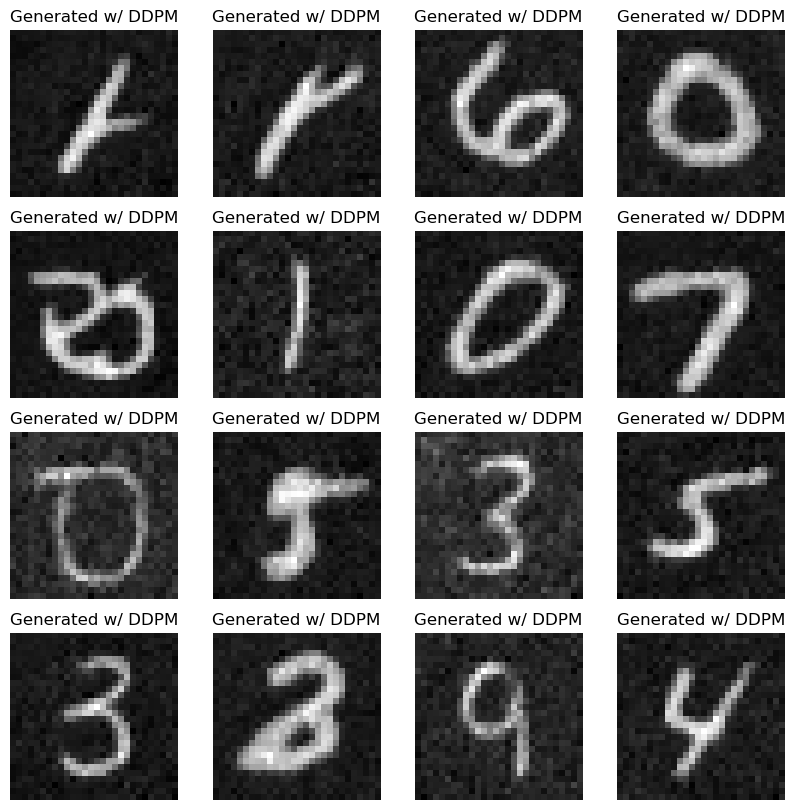

epoch= 6 	 time= 1.4999091664950053 min 	 lr= 0.0003 	 loss= 0.04049610757889847
epoch= 7 	 time= 1.7261693398157756 min 	 lr= 0.0003 	 loss= 0.03918199341433744
epoch= 8 	 time= 1.947707231839498 min 	 lr= 0.0003 	 loss= 0.03899386271213492
epoch= 9 	 time= 2.166409766674042 min 	 lr= 0.0003 	 loss= 0.03802799843251705
epoch= 10 	 time= 2.386112948258718 min 	 lr= 0.0003 	 loss= 0.03754400407895446
num_steps: 150 set_t: [148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 1

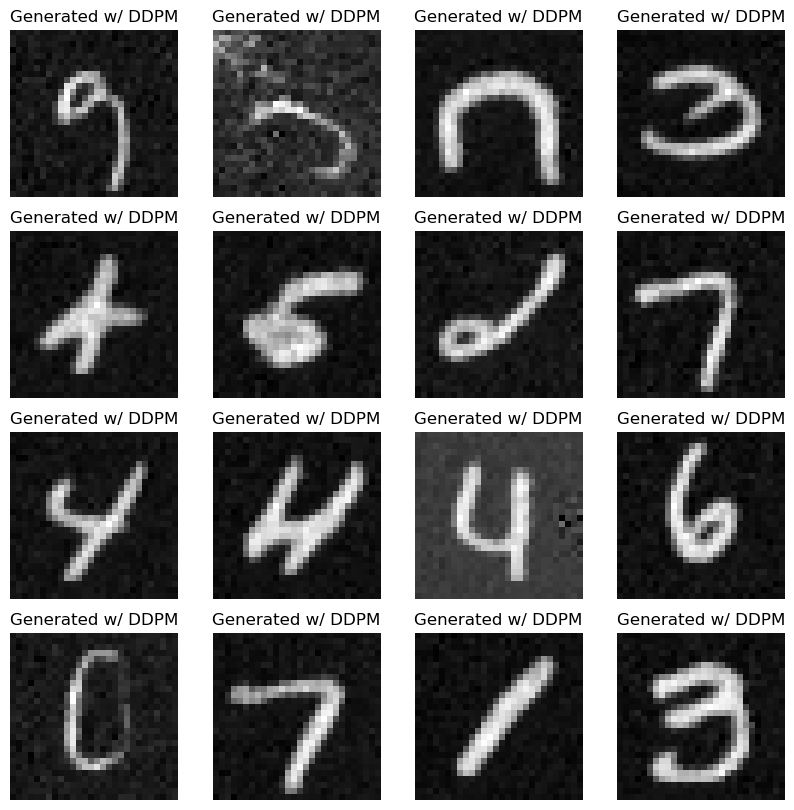

epoch= 11 	 time= 2.6810868978500366 min 	 lr= 0.0003 	 loss= 0.03722050189351042
epoch= 12 	 time= 2.9778212269147235 min 	 lr= 0.0003 	 loss= 0.03672336633317173
epoch= 13 	 time= 3.274003485838572 min 	 lr= 0.0003 	 loss= 0.03658523682815333
epoch= 14 	 time= 3.571525796254476 min 	 lr= 0.0003 	 loss= 0.03628598395114144
epoch= 15 	 time= 3.8686267177263898 min 	 lr= 0.0003 	 loss= 0.03612492678376535
num_steps: 150 set_t: [148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 

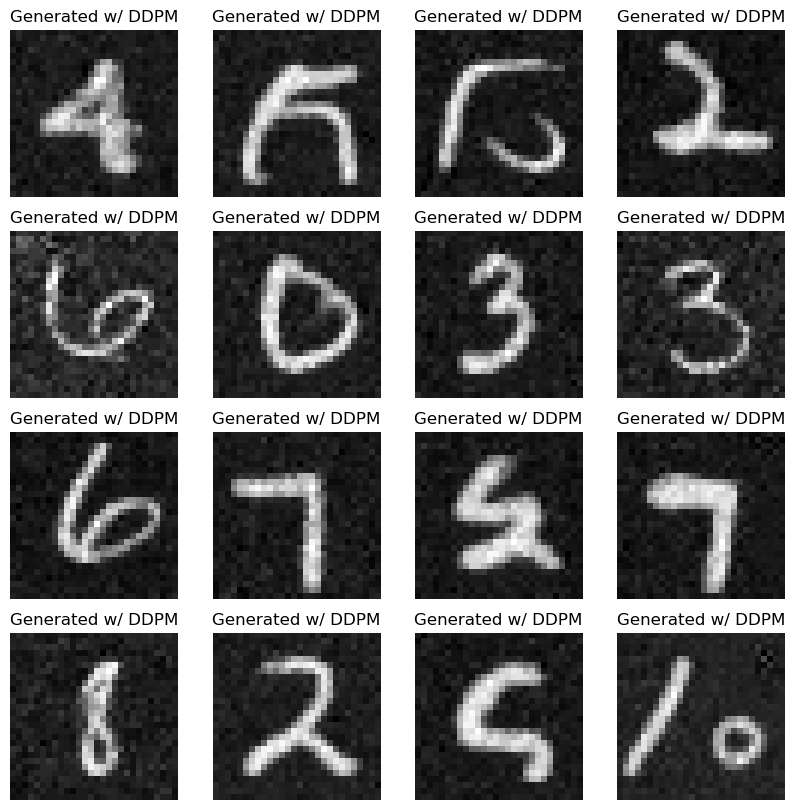

epoch= 16 	 time= 4.1852872212727865 min 	 lr= 0.0003 	 loss= 0.03595934128699203
epoch= 17 	 time= 4.482491807142893 min 	 lr= 0.0003 	 loss= 0.035793537438536686
epoch= 18 	 time= 4.780918848514557 min 	 lr= 0.0003 	 loss= 0.03531742157414555
epoch= 19 	 time= 5.080540931224823 min 	 lr= 0.0003 	 loss= 0.03534463466455539


In [11]:
## Training loop
net = DDPM(num_t, beta_1, beta_T)
net = net.to(device)
display_num_param(net)

# Optimizer
init_lr = 0.0003
optimizer = torch.optim.Adam(net.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1, verbose=True)

# Number of mini-batches per epoch
nb_epochs = 20

# Training loop
start = time.time()
for epoch in range(nb_epochs):

    running_loss = 0.0
    num_batches = 0

    shuffled_indices = torch.randperm(60000)

    for count in range(0,60000,bs):

        idx_images = shuffled_indices[count : count+bs]
        batch_x0 = train_data[idx_images,:,:].to(device) # [bs, n, n]
        batch_sample_t = torch.randint(0, num_t, (bs,)).long().to(device) # [bs]
        batch_noise_t = torch.randn(batch_x0.size()).to(device) # [bs, n, n]
        x_t = net.forward_process(batch_x0, batch_sample_t, batch_noise_t) # [bs, n, n]
        noise_pred_t = net.backward_process(x_t, batch_sample_t) # [bs, n, n]
        loss_PPDM = torch.nn.MSELoss()(noise_pred_t, batch_noise_t)
        loss = loss_PPDM
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # COMPUTE STATS
        running_loss += loss.detach().item()
        num_batches += 1

    # AVERAGE STATS THEN DISPLAY
    total_loss = running_loss/num_batches
    scheduler.step(total_loss)
    elapsed = (time.time()-start)/60
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t lr=', optimizer.param_groups[0]['lr']  ,'\t loss=', total_loss )

    # PLOT
    if epoch>0 and not epoch%5:
        with torch.no_grad():
            num_generated_images = 16
            batch_x_0 = net.generate_process_ppdm(num_generated_images)
            x_hat = batch_x_0.squeeze().detach().to('cpu')
        figure, axis = plt.subplots(4, 4)
        figure.set_size_inches(10,10)
        i,j,cpt=0,0,0; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=1,0,1; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=2,0,2; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=3,0,3; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=0,1+0,4; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=1,1+0,5; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=2,1+0,6; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=3,1+0,7; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=0,2+0,8; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=1,2+0,9; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=2,2+0,10; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=3,2+0,11; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=0,3+0,12; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=1,3+0,13; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=2,3+0,14; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        i,j,cpt=3,3+0,15; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
        plt.show()

    # Check lr value
    if optimizer.param_groups[0]['lr'] < 2*10**-4: 
        print("\n lr is equal to min lr -- training stopped\n")
        break
         

num_steps: 150 set_t: [148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
batch_x_0 torch.Size([16, 28, 28])


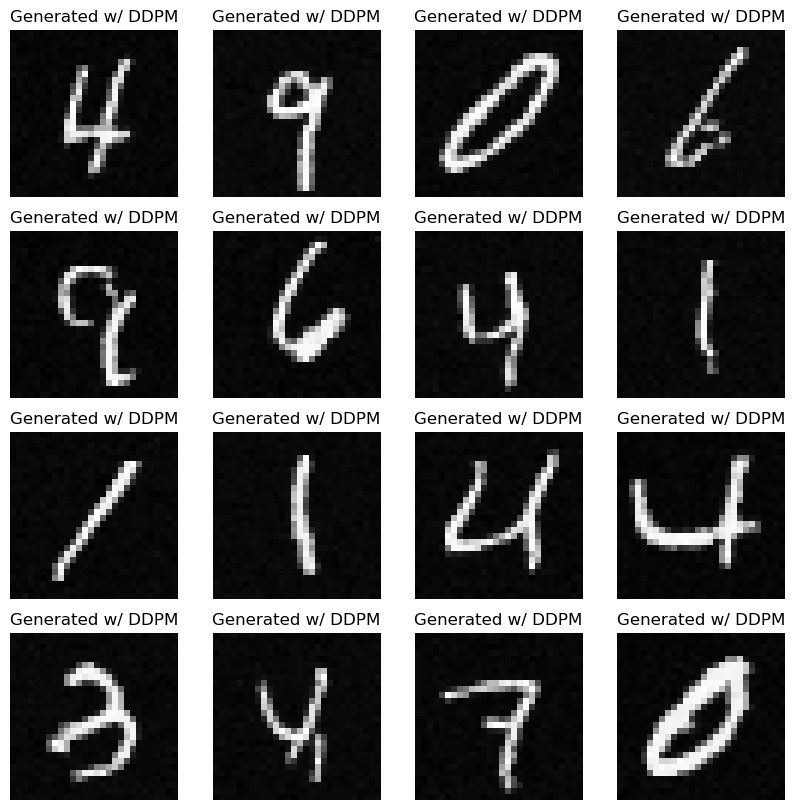

In [12]:
# Generated images with DDPM

net.eval()
with torch.no_grad():
    num_generated_images = 16
    batch_x_0 = net.generate_process_ppdm(num_generated_images)
    print('batch_x_0',batch_x_0.size())
    x_hat = batch_x_0.squeeze().detach().to('cpu')

figure, axis = plt.subplots(4, 4)
figure.set_size_inches(10,10)

i,j,cpt=0,0,0; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=1,0,1; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=2,0,2; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=3,0,3; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=0,1+0,4; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=1,1+0,5; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=2,1+0,6; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=3,1+0,7; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=0,2+0,8; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=1,2+0,9; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=2,2+0,10; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=3,2+0,11; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=0,3+0,12; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=1,3+0,13; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=2,3+0,14; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')
i,j,cpt=3,3+0,15; axis[i,j].imshow(x_hat[cpt,:,:], cmap='gray'); axis[i,j].set_title("Generated w/ DDPM"); axis[i,j].axis('off')

plt.show()